# confusion matrix vizualize

In [14]:
from collections import namedtuple
import os
import argparse
import random
from datetime import datetime
from glob import glob

import wandb
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

from utils import *
from metric import accuracy, macro_f1
from dataset import MulitaskDataset
from model import CustomModel, MultitaskModel
from process import train, validation
from loss import MultitaskLoss, create_criterion

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [20]:
parser = argparse.ArgumentParser()
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--val_ratio", type=float, default=0.3)  # train-val slit ratio
parser.add_argument("--split_option", type=str, default="different")  # different or none
parser.add_argument("--stratify", type=bool, default=True)
parser.add_argument("--wrs", type=bool, default=True)

parser.add_argument("--age_pred", type=str, default="classification") # classification or regression or ordinary or cls_regression 
parser.add_argument("--loss_type", type=str, default="focal")
parser.add_argument("--lam", type=int, default=2)
parser.add_argument("--age_normalized", type=str, default="normal") # normal or minmax
parser.add_argument("--lowwer", type=float, default=0.5) # for regression cls_regression
parser.add_argument("--upper", type=float, default=1.5) # for regression cls_regression

parser.add_argument("--in_size", type=int, default=256) # input size image
parser.add_argument("--crop_type", type=str, default="center") # crop type : center or random or random_resized
parser.add_argument("--degrees", type=int, default=0) # rotation degree
parser.add_argument("--translate", type=float, default=0.1) # translate ratio

parser.add_argument("--backbone_name", type=str, default="resnet50")
parser.add_argument("--activation_head", type=bool, default=True) # actviation for age head
parser.add_argument("--dropout", type=float, default=0.2)

# parser.add_argument("--num_epochs", type=int, default=50)
# parser.add_argument("--lr", type=float, default=0.01)
# parser.add_argument("--weight_decay", type=float, default=1e-4)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--n_workers", type=int, default=4)

parser.add_argument("--train_dir", type=str, default="/opt/ml/input/data/train")
parser.add_argument("--save_dir", type=str, default="/opt/ml/experiment/")
parser.add_argument("--project_name", type=str, default="multitask")
# parser.add_argument(
#     "--experiment_name",
#     type=str,
#     default="regression - wrs&original dataset",
# )
args = parser.parse_args(args=[])
age_stat = None # for regression only
set_seed(args.seed)

In [21]:
all_csv = pd.read_csv(os.path.join(args.train_dir, "train.csv"))
all_csv = csv_preprocess(all_csv)
if args.split_option == "different":        
    if args.stratify:
        train_csv, val_csv = train_test_split(
            all_csv,
            test_size=args.val_ratio,
            shuffle=True,
            random_state=args.seed,
            stratify=all_csv["age_category"],  # age_class stratify
        )
    else:
        train_csv, val_csv = train_test_split(
            all_csv,
            test_size=args.val_ratio,
            shuffle=True,
            random_state=args.seed,  # no stratify
        )
    train_data = increment_path(os.path.join(args.train_dir, "images"), train_csv)
    val_data = increment_path(os.path.join(args.train_dir, "images"), val_csv)
else:
    data = increment_path(os.path.join(args.train_dir, "images"), all_csv)
    if args.stratify:
        train_data, val_data = train_test_split(
            data,
            test_size=args.val_ratio,
            shuffle=True,
            random_state=args.seed,
            stratify=data[:, 3],  ## age_class stratify
        )
    else:
        train_data, val_data = train_test_split(
            data,
            test_size=args.val_ratio,
            shuffle=True,
            random_state=args.seed,  ## no stratify
        )

### age preprocess ###
if args.age_pred == 'regression':
    if args.age_normalized == 'normal':
        Statistic = namedtuple('Statistic', ['mean', 'std'])
        tmp = train_data[:,2].astype(np.float)
        age_stat = Statistic(mean=tmp.mean(),std=tmp.std())
        train_data[:,2] = (tmp-age_stat.mean)/age_stat.std

        tmp = val_data[:,2].astype(np.float)
        val_data[:,2] = (tmp-age_stat.mean)/age_stat.std
    elif args.age_normalized == 'minmax':
        Statistic = namedtuple('Statistic', ['min', 'max'])
        tmp = train_data[:,2].astype(np.float)
        age_stat = Statistic(min=tmp.min(),max=tmp.max())
        train_data[:,2] = (tmp-age_stat.min)/(age_stat.max -age_stat.min)

        tmp = val_data[:,2].astype(np.float)
        val_data[:,2] = (tmp-age_stat.min)/(age_stat.max -age_stat.min)

train_transform, val_transform = build_transform(
    args=args, phase="train"
)  # data augmentation
train_dataset = MulitaskDataset(
    args.train_dir, train_data, transform=train_transform
)
val_dataset = MulitaskDataset(args.train_dir, val_data, transform=val_transform)

val_loader = DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.n_workers,
)

In [22]:
def local_validation(args, epoch, model, loader, loss_fn, age_stat=None, print_info = False):
    model.eval()
    preds, labels = torch.tensor([]), torch.tensor([])
    info, time, num = defaultdict(int), datetime.now(), 0
    with torch.no_grad():

        # for img, label in tqdm(loader):
        for img, label, gen, age, age_category, mask in loader:
            img, label, gen, age, age_category, mask = (
                img.cuda(),
                label.cuda(),
                gen.cuda(),
                age.cuda(),
                age_category.cuda(),
                mask.cuda(),
            )

            
            gen_pred, age_pred, mask_pred = model(img)
            if args.age_pred == 'classification':
                gen_loss, age_loss, mask_loss = loss_fn(
                    gen_pred, age_pred, mask_pred, gen, age_category, mask
                )
                loss = gen_loss + age_loss + mask_loss
            elif args.age_pred == 'regression':
                age = age.unsqueeze(-1)
                gen_loss, age_loss, mask_loss = loss_fn(
                    gen_pred, age_pred, mask_pred, gen, age, mask
                )
                loss = gen_loss + age_loss + mask_loss # age loss weight?
            elif args.age_pred == 'ordinary':
                pass
            elif args.age_pred == 'cls_regression':
                age_category = age_category.float().unsqueeze(-1)
                gen_loss, age_loss, mask_loss = loss_fn(
                    gen_pred, age_pred, mask_pred, gen, age_category, mask
                )
                loss = gen_loss + age_loss + mask_loss # age loss weight?
                
            pred = make_class(args, gen_pred.cpu(), age_pred.cpu(), mask_pred.cpu(), age_stat)
            preds = torch.cat((preds, pred))
            labels = torch.cat((labels, label.cpu()))
            info["val_total_loss"] += loss.item() / len(loader)

    f1_all = macro_f1(labels, preds, return_all=True)
    info["val_f1"] = sum(f1_all) / len(f1_all)
    info["val_gen_f1"] = macro_f1((labels // 3) % 2, (preds // 3) % 2)
    age_f1_all = macro_f1(labels % 3, preds % 3, return_all=True)
    info["val_age_f1"] = sum(age_f1_all) / len(age_f1_all)
    info["val_age_f1_0"], info["val_age_f1_1"], info["val_age_f1_2"] = age_f1_all

    info["val_mask_f1"] = macro_f1(labels // 6, preds // 6)

    info["epoch"] = epoch
    info["val_acc"] = accuracy(labels, preds)
    elapsed = datetime.now() - time
    if print_info:
        print(
            "[val] f1 {:.3f} | acc {:.3f} | loss {:.3f} | elapsed {}".format(
                info["val_f1"], info["val_acc"], info["val_total_loss"], elapsed
            )
        )
        print(
            "[val] gen f1 {:.3f} | age f1 {:.3f} | mask f1 {:.3f} ".format(
                info["val_gen_f1"], info["val_age_f1"], info["val_mask_f1"]
            )
        )
        print(
            "[val] age=0 f1 {:.3f} | age=1 f1 {:.3f} | age=2 f1 {:.3f} ".format(
                info["val_age_f1_0"], info["val_age_f1_1"], info["val_age_f1_2"]
            )
        )
        print(
            "[val] 5 smallest f1",
            dict(
                sorted(
                    [(i, round(f1_all[i], 3)) for i in range(len(f1_all))],
                    key=lambda x: x[1],
                )[:5]
            ),
        )
    return labels, preds


In [23]:
def cm_viz(model_path, print_info=False):
    global y_true, y_pred
    ckpt = torch.load(model_path)
    model.load_state_dict(ckpt["model"])
    y_true, y_pred = local_validation(
        args=args,
        epoch=-1,
        model=model,
        loader=val_loader,
        loss_fn=loss_fn,
        age_stat=age_stat,
        print_info = print_info,
    )
    cm = confusion_matrix(y_true,y_pred)
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, range(18), range(18))
    sn.set(rc={'figure.figsize':(20,20)},font_scale=1.6) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, cmap='inferno')
    plt.title("/".join(model_path.split('/')[-3:]))
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.savefig('cm.png')
    plt.show()

In [24]:
MultitaskModel(args).head

MultitaskHead(
  (gen_head): Linear(in_features=2048, out_features=2, bias=True)
  (mask_head): Linear(in_features=2048, out_features=3, bias=True)
  (age_head): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): GELU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [25]:
# args.upper = 1.5

[val] f1 0.830 | acc 0.901 | loss 0.137 | elapsed 0:00:10.384481
[val] gen f1 0.985 | age f1 0.849 | mask f1 0.994 
[val] age=0 f1 0.961 | age=1 f1 0.909 | age=2 f1 0.676 
[val] 5 smallest f1 {11: 0.649, 8: 0.651, 14: 0.651, 2: 0.67, 5: 0.685}


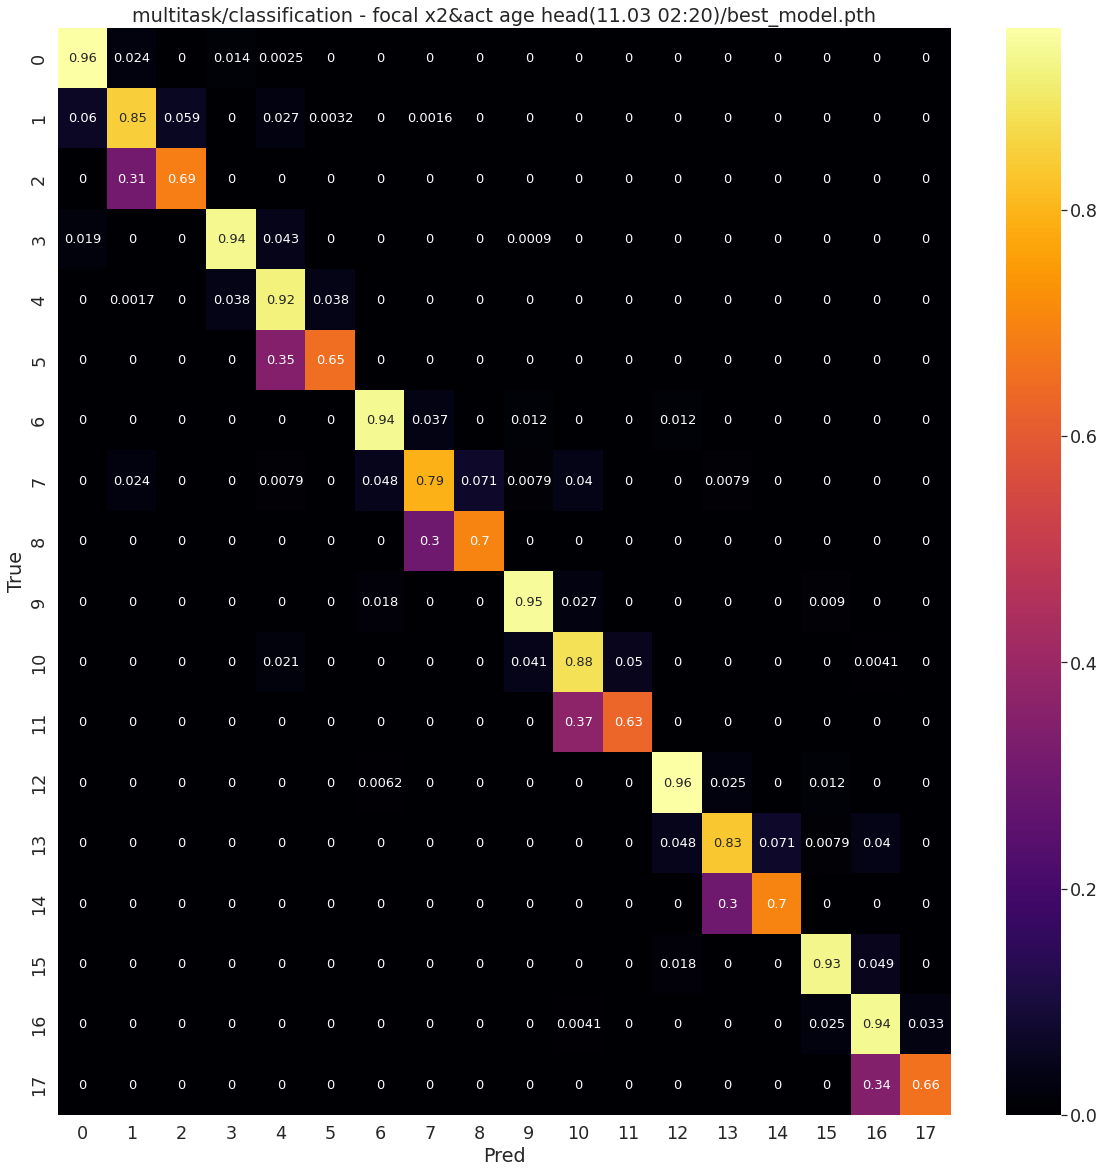

In [26]:
model = MultitaskModel(args).cuda()
loss_fn = MultitaskLoss(args).cuda()
cm_viz('/opt/ml/experiment/multitask/classification - focal x2&act age head(11.03 02:20)/best_model.pth',True)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[val] f1 0.802 | acc 0.878 | loss 0.203 | elapsed 0:00:10.040601
[val] gen f1 0.974 | age f1 0.822 | mask f1 0.992 
[val] age=0 f1 0.962 | age=1 f1 0.893 | age=2 f1 0.611 
[val] 5 smallest f1 {2: 0.489, 8: 0.588, 14: 0.64, 5: 0.643, 11: 0.667}


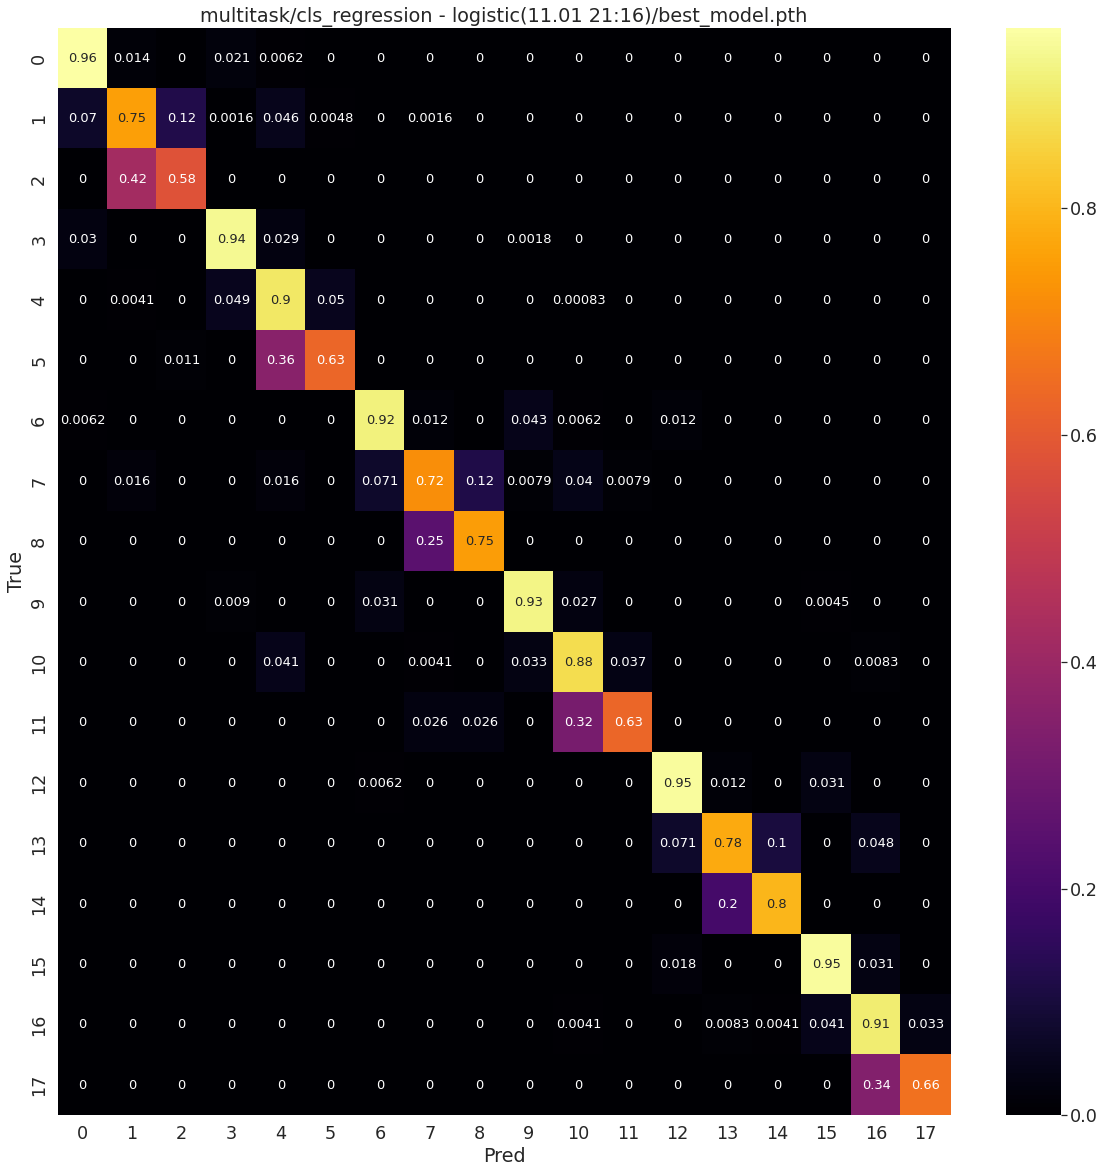

In [7]:
model = MultitaskModel(args).cuda()
loss_fn = MultitaskLoss(args).cuda()
cm_viz('/opt/ml/experiment/multitask/cls_regression - logistic(11.01 21:16)/best_model.pth',True)

# show wrong example

In [45]:
age2_index = (y_pred%3 == 2).nonzero(as_tuple=True)[0]

In [38]:
true_age = torch.tensor([])
for img, label, gen, age, age_category, mask in val_loader:
    true_age = torch.cat((true_age,age))

In [116]:
pred2_real_age = true_age[age2_index]

In [117]:
pred2_real_age[(pred2_real_age<60).nonzero(as_tuple=True)[0]]

tensor([55., 58., 58., 58., 58., 58., 59., 59., 58., 58., 57., 55., 55., 55.,
        55., 55., 59., 59., 59., 59., 59., 59., 48., 55., 58., 58., 57., 55.,
        55., 59., 59., 59., 59., 59., 59., 59., 58., 58., 58., 58., 56., 56.,
        59., 59., 53., 53., 53., 53., 53., 53., 53., 59., 59., 59., 53., 53.,
        56., 56., 56., 55., 55., 58., 58., 58., 58., 58., 58., 58., 58., 58.,
        58., 58., 58., 55., 57., 56., 58., 59., 59., 59., 59., 59., 59., 59.,
        59., 59., 59., 59., 59., 59., 53., 59., 59., 59., 47., 47., 56., 56.,
        56., 56., 56., 40., 57., 58., 58., 58., 58., 55., 56., 52., 52., 58.,
        56., 56., 58., 58., 58., 58., 58., 58., 58., 59., 59., 59., 59., 59.,
        59., 59., 50., 58.])